<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY-9163-ML-cyber/blob/main/Lab/Lab3/MLSec_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3
You must do the project individually. In this HW you will design a backdoor detector for 
BadNets trained on the YouTube Face dataset using the pruning defense discussed in 
class. Your detector will take as input:
1. B, a backdoored neural network classifier with N classes.
2. Dvalid, a validation dataset of clean, labelled images.

What you must output is G a “repaired” BadNet. G has N+1 classes, and given unseen test 
input, it must: 
1. Output the correct class if the test input is clean. The correct class will be in [1,N].
2. Output class N+1 if the input is backdoored.

You will design G using the pruning defense that we discussed in class. That is, you will prune the last convlution layer of BadNet B (the layer just before the FC layers, it should has the pooling layer after) by removing one 
channel at a time from that layer. Channels should be removed in increasing order of average activation values over the entire validation set. Every time you prune a channel, you will  measure the new validation accuracy of the new pruned badnet. You will stop pruning once the  validation accuracy drops atleast X% below the original accuracy. This will be your new 
network B'. Now, your goodnet G works as follows. For each test input, you will run it through both B and  B'. If the classification outputs are the same, i.e., class i, you will output class i. If they differ you  will output N+1. Evaluate this defense on:
1. A BadNet, B1, (“sunglasses backdoor”) on YouTube Face for which we have already  told you what the backdoor looks like. That is, we give you the validation data, and  also test data with examples of clean and backdoored inputs.

Now you must submit:
1. Your repaired networks for X={2%,4%,10%}. The repaired networks will be evaluated using the evaluation script (eval.py) on this website https://github.com/csaw-hackml/CSAW-HackML-2020. This website hosts all the information and data for the project.
2. Plot the accuracy on clean test data and the attack success rate (on backdoored test 
data) as a function of the fraction of channels pruned. 
3. Please create and submit a link to a GitHub repo. with any/all code you have produced in this project along with a Readme that tells us how to run your code and your HW report.
4. Please also report attack success rate for X=30%
5. Finally, in your report, also comment on whether the pruning defense works for this model? If not, why not? 



## Import package

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
warnings.filterwarnings("ignore")

## bd_net
It shows the original badnet and it will print out the accuracy and attack success rate for the original badnet

In [ ]:
clean_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/clean/valid.h5'
poisoned_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/bd/bd_valid.h5'
model_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Model/bd_net.h5'

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


Here, we will see the model structure

In [ ]:
model = keras.models.load_model(model_filename)

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Here, we will visualize the data to see what the clean data looks like.

In [ ]:
x_data, y_data = data_loader(clean_data_filename)

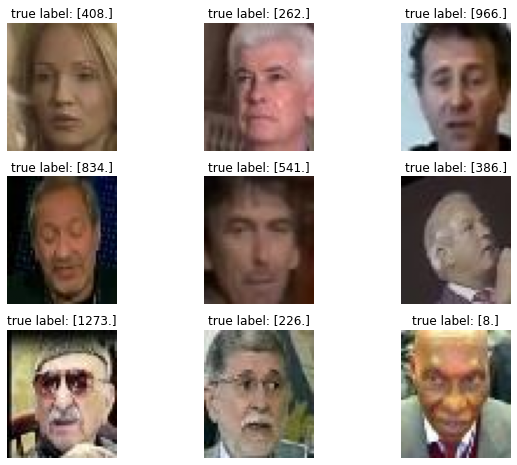

In [ ]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Here, we will also visulize the poisoned data that has the sunglasses

In [ ]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)

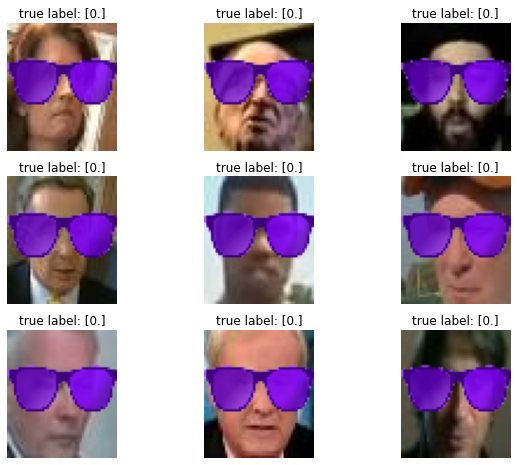

In [ ]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [ ]:
keras.backend.clear_session()

## Prune defense
Here, we will prune the model. First, we will check the activation of the last pooling layer ("pool_3") and always prune the smallest average actiavtion (average the entire validation dataset). For convolution layer (conv_3), there are 60 channels in total and we need to get the index to prune. 

In [ ]:
## get the clean and poisoned data
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

In [ ]:
clean_data_acc = 98.64899974019225 # original accuracy, get it from the begining
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

## get the activation from 'pool_3'
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()


  2%|▏         | 1/60 [00:18<17:58, 18.27s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  3%|▎         | 2/60 [00:36<17:40, 18.29s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  5%|▌         | 3/60 [00:54<17:25, 18.34s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  7%|▋         | 4/60 [01:13<17:07, 18.35s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30


  8%|▊         | 5/60 [01:31<16:46, 18.31s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31


 10%|█         | 6/60 [01:52<17:18, 19.23s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33


 12%|█▏        | 7/60 [02:11<16:46, 18.98s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 13%|█▎        | 8/60 [02:29<16:16, 18.79s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36


 15%|█▌        | 9/60 [02:47<15:50, 18.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37


 17%|█▋        | 10/60 [03:03<14:46, 17.72s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 18%|█▊        | 11/60 [03:24<15:17, 18.73s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25


 20%|██        | 12/60 [03:45<15:32, 19.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39


 22%|██▏       | 13/60 [04:03<14:58, 19.13s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41


 23%|██▎       | 14/60 [04:19<13:50, 18.06s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44


 25%|██▌       | 15/60 [04:40<14:12, 18.96s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45


 27%|██▋       | 16/60 [05:01<14:23, 19.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47


 28%|██▊       | 17/60 [05:17<13:14, 18.48s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48


 30%|███       | 18/60 [05:33<12:22, 17.68s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49


 32%|███▏      | 19/60 [05:54<12:48, 18.75s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 33%|███▎      | 20/60 [06:10<11:55, 17.88s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53


 35%|███▌      | 21/60 [06:28<11:44, 18.06s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55


 37%|███▋      | 22/60 [06:47<11:32, 18.22s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40


 38%|███▊      | 23/60 [07:03<10:48, 17.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 40%|████      | 24/60 [07:21<10:40, 17.80s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59


 42%|████▏     | 25/60 [07:43<10:59, 18.83s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9


 43%|████▎     | 26/60 [08:04<11:02, 19.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2


 45%|████▌     | 27/60 [08:25<10:58, 19.95s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12


 47%|████▋     | 28/60 [08:43<10:25, 19.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13


 48%|████▊     | 29/60 [08:59<09:31, 18.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17


 50%|█████     | 30/60 [09:20<09:36, 19.21s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14


 52%|█████▏    | 31/60 [09:36<08:51, 18.34s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15


 53%|█████▎    | 32/60 [09:55<08:34, 18.38s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23


 55%|█████▌    | 33/60 [10:11<07:56, 17.65s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6


 57%|█████▋    | 34/60 [10:30<07:47, 17.99s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 58%|█████▊    | 35/60 [10:45<07:12, 17.31s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32


 60%|██████    | 36/60 [11:04<07:03, 17.64s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22


 62%|██████▏   | 37/60 [11:20<06:35, 17.20s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21


 63%|██████▎   | 38/60 [11:38<06:26, 17.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20


 65%|██████▌   | 39/60 [11:59<06:30, 18.61s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19


 67%|██████▋   | 40/60 [12:21<06:28, 19.45s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43


 68%|██████▊   | 41/60 [12:37<05:49, 18.41s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58


 70%|███████   | 42/60 [12:55<05:32, 18.45s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3


 72%|███████▏  | 43/60 [13:14<05:15, 18.59s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42


 73%|███████▎  | 44/60 [13:33<04:56, 18.54s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
The accuracy drops at least 2%, saved the model


 75%|███████▌  | 45/60 [13:54<04:49, 19.30s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29


 77%|███████▋  | 46/60 [14:10<04:18, 18.45s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16


 78%|███████▊  | 47/60 [14:26<03:50, 17.75s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
The accuracy drops at least 4%, saved the model


 80%|████████  | 48/60 [14:45<03:36, 18.06s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46


 82%|████████▏ | 49/60 [15:02<03:14, 17.66s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5


 83%|████████▎ | 50/60 [15:18<02:51, 17.11s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8


 85%|████████▌ | 51/60 [15:36<02:38, 17.59s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
The accuracy drops at least 10%, saved the model


 87%|████████▋ | 52/60 [15:58<02:29, 18.74s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54


 88%|████████▊ | 53/60 [16:19<02:15, 19.43s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10


 90%|█████████ | 54/60 [16:40<01:59, 19.91s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28


 92%|█████████▏| 55/60 [16:59<01:38, 19.66s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35


 93%|█████████▎| 56/60 [17:18<01:17, 19.39s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18


 95%|█████████▌| 57/60 [17:36<00:57, 19.15s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4


 97%|█████████▋| 58/60 [17:55<00:38, 19.02s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7


 98%|█████████▊| 59/60 [18:11<00:17, 17.99s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52


100%|██████████| 60/60 [18:29<00:00, 18.49s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


The result is shown below. We can see that the defense is not too successful because it compromises the accuracy.

In [51]:
print("clean_accuracy: ",clean_acc)
print("attack success rate: ",asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

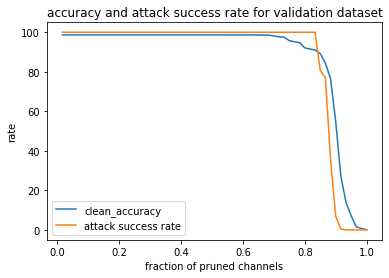

In [ ]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [50]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ",asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


## Combined models
And now, we need to combine two models which are B (original badnet model) and B' (pruned model). The goodnet is our combined model. If the preditions from B and B' are same, then the goodnet will output the predition, 1283 otherwise. Outputing 1283 means backdoored inout

In [ ]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluate the combined model

In [ ]:
test_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/clean/test.h5'
poisoned_test_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/bd/bd_test.h5'
test_model_X_2_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Model/model_X=2.h5'
test_model_X_4_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Model/model_X=4.h5'
test_model_X_10_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Model/model_X=10.h5'

In [ ]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [ ]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [ ]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [56]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

Evaluate on the test dataset

In [57]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, the clean test data Classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, the clean test data Classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

2% drops model, the clean test data Classification accuracy: 95.90023382696803
2% drops model, Attack Success Rate: 100.0
4% drops model, the clean test data Classification accuracy: 92.29150428682775
4% drops model, Attack Success Rate: 99.98441153546376
10% drops model, the clean test data Classification accuracy: 84.54403741231489
10% drops model, Attack Success Rate: 77.20966484801247


And summarize the repaired models

In [54]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


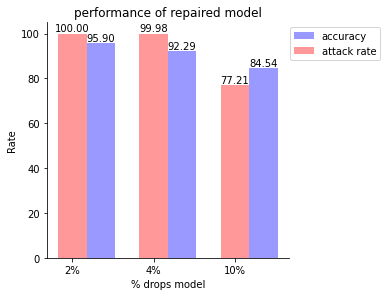

In [63]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

These are the goonets that combines two models which are original badNet and the repaired model

In [61]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [62]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


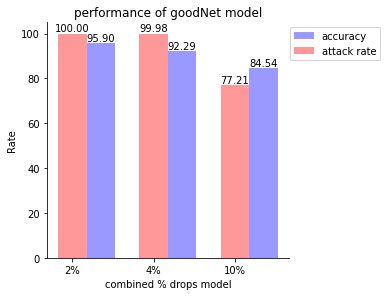

In [64]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()

We can see that the prune defense is not too successful here. I think the attack is prune aware attack that the pruned model is retrained with poisoned data. And the weight is changed again so that the model will have the wrong predition.  